<a href="https://githubtocolab.com/borislevant/python4cv/blob/main/edges_canny_hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Edge detection: from gradients to Canny filter
## by Dr. Boris Levant

[![scikit-learn logo](./img/opencv-logo-small.png)](https://docs.opencv.org/3.4/d0/de3/tutorial_py_intro.html)

Edge detection includes a variety of mathematical methods that aim at identifying edges, curves in a digital image at which the image brightness changes sharply or, more formally, has discontinuities. The purpose of detecting sharp changes in image brightness is to capture important events and changes in properties of the world. It can be shown that under rather general assumptions for an image formation model, discontinuities in image brightness are likely to correspond to:
* discontinuities in depth
* discontinuities in surface orientation
* changes in material properties
* variations in scene illumination

In the ideal case, the result of applying an edge detector to an image may lead to a set of connected curves that indicate the boundaries of objects, the boundaries of surface markings as well as curves that correspond to discontinuities in surface orientation. Thus, applying an edge detection algorithm to an image may significantly reduce the amount of data to be processed and may therefore filter out information that may be regarded as less relevant, while preserving the important structural properties of an image. If the edge detection step is successful, the subsequent task of interpreting the information contents in the original image may therefore be substantially simplified. However, it is not always possible to obtain such ideal edges from real life images of moderate complexity.



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Simple gradients of the image

Let's first create the simplest possible image to try the simplest filters - gradients. We can use the OpenCV functions to draw the different shapes. In general, OpenCV has a number of drawing functions you can use to draw various shapes, including polygons of irregular shapes, but the three most common OpenCV drawing functions you will see are:

* cv2.line: Draws a line on image, starting at a specified (x, y)-coordinate and ending at another (x, y)-coordinate
* cv2.circle: Draws a circle on an image specified by the center (x, y)-coordinate and a supplied radius
* cv2.rectangle: Draws a rectangle on an image specified by the top-left corner and bottom-right corner (x, y)-coordinates
* cv2.ellipse: Draws an ellipse on an image
* cv2.polylines: Draws the outline of a polygon specified by a set of (x, y)-coordinates
* cv2.fillPoly: Draws a polygon, but instead of drawing the outline, instead fills in the polygon
* cv2.arrowedLine: Draws an arrow pointing from a starting (x, y)-coordinate to an ending (x, y)-coordinate

These OpenCV drawing functions are used less often but are still worth noting. One can look in this tutorial for more informatio:
https://pyimagesearch.com/2021/01/27/drawing-with-opencv/

The following code creates the clean image with a few geometric figures. Please, take a few minutes to play with it and understand the possibilities


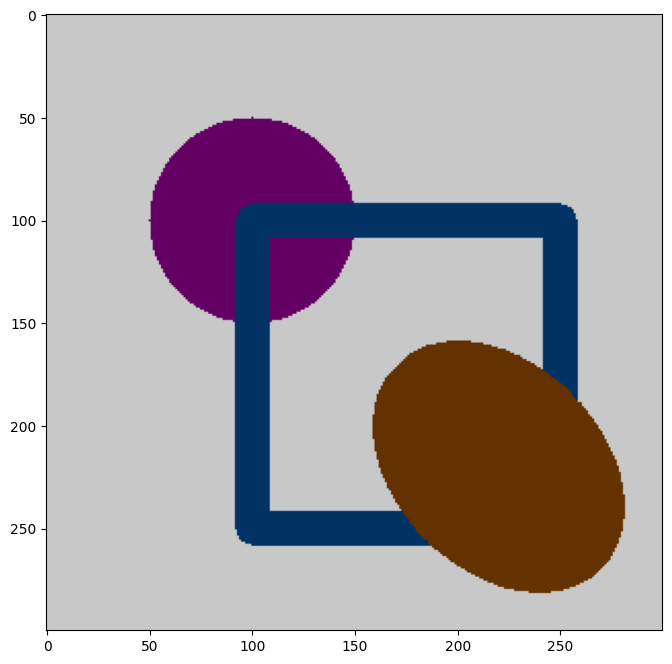

In [2]:
img_rect = np.zeros((300, 300, 3)).astype(np.uint8)+200
cv2.circle(img_rect, center=(100, 100), radius=50, color=(100, 0, 100), thickness=-1)
cv2.rectangle(img_rect, pt1=(100, 100), pt2=(250, 250), color=(0, 50, 100), thickness=15)
cv2.ellipse(img_rect, center=(220, 220), axes=(70, 50), 
            angle=45, startAngle=0, endAngle=360, color=(100, 50, 0), thickness=-1)

plt.figure(figsize=(8, 8))
plt.imshow(img_rect)

Let's create the simplest possible edge detection. For that we will use the following algorithm:
1. Turn the image into grayscale
2. Compute the derivatives of the image $G_x = \frac{\partial}{\partial x}$ and $G_y = \frac{\partial}{\partial y}$ in the direction x and y using the function ```diff``` of the ```numpy```
3. Compute the gradient of the image
$$
G(I) = \sqrt{G_x^2(I) + G_y^2(I)}
$$
4. In addition we would like to compute the orientation of the gradient
$$
\theta(I) = \arctan(G_y, G_x) \cdot(\frac{180}{\pi})
$$

In [3]:
def gradient_simple(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = np.diff(img_gray, axis=1, append=0)
    grad_y = np.diff(img_gray, axis=0, append=0)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_orient = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180
    return img_gray, grad_x, grad_y, grad, grad_orient

def show_gradients(img, img_gray, grad_x, grad_y, grad, grad_orient):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original Image')
    ax[0, 1].imshow(img_gray, cmap='gray')
    ax[0, 1].set_title('Gray Image')
    ax[1, 0].imshow(grad_x, cmap='gray')
    ax[1, 0].set_title('Gradient in direction X')
    ax[1, 1].imshow(grad_y, cmap='gray')
    ax[1, 1].set_title('Gradient in direction Y')
    ax[2, 0].imshow(grad, cmap='jet')
    ax[2, 0].set_title('Magnitude of the Gradient')
    ax[2, 1].imshow(grad_orient, cmap='jet')
    ax[2, 1].set_title('Orientation of the Gradient')
    plt.show()


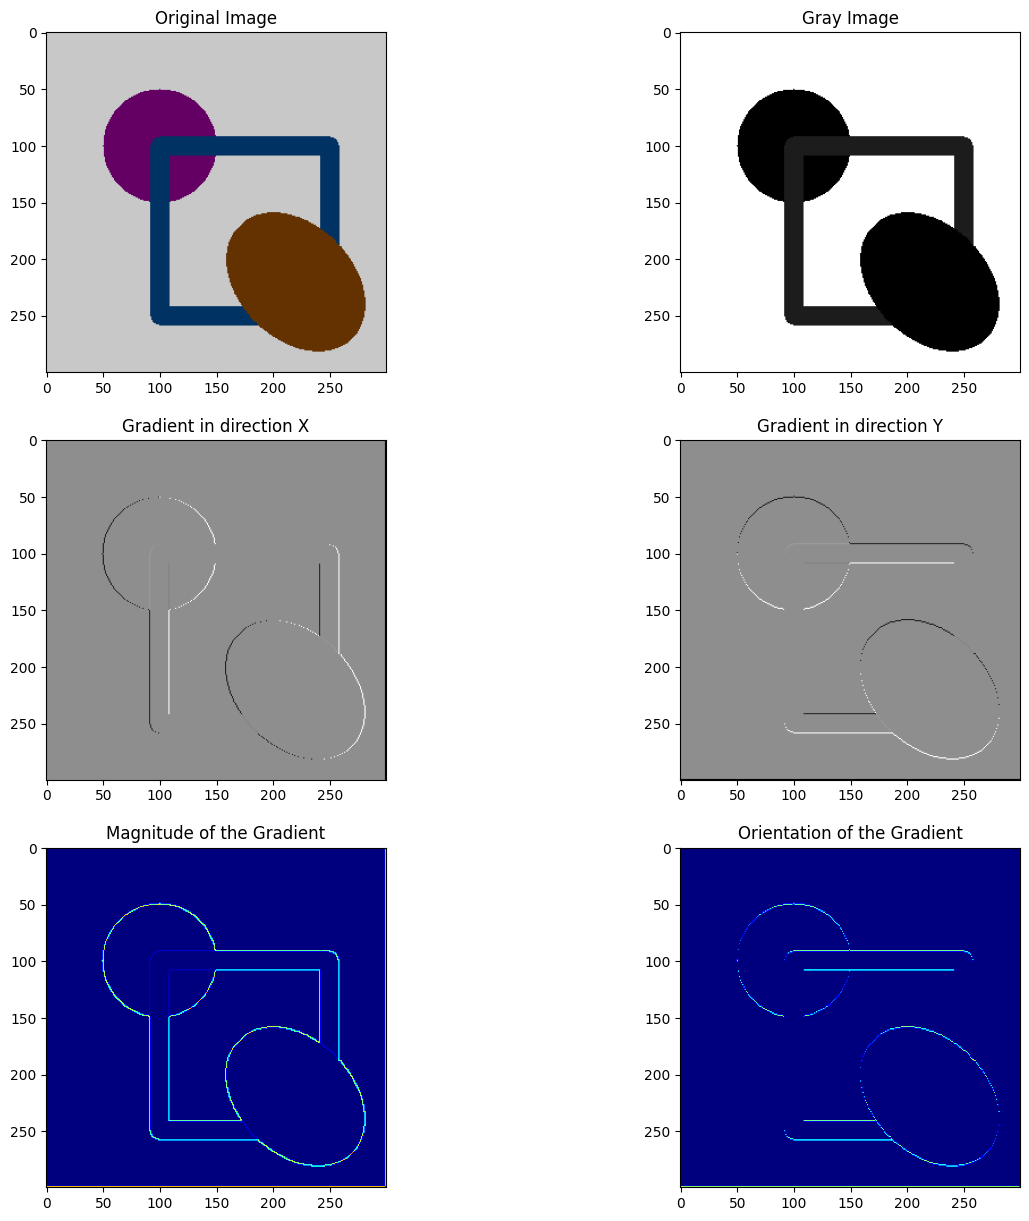

In [4]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_simple(img_rect)
show_gradients(img_rect, img_gray, grad_x, grad_y, grad, grad_orient)


This simplest possible implementation of the Edge detector - Magnitude of the gradient - has a few important drawbacks. It's very sensitive to the noise. Therefore, we have to add something more sofisticated

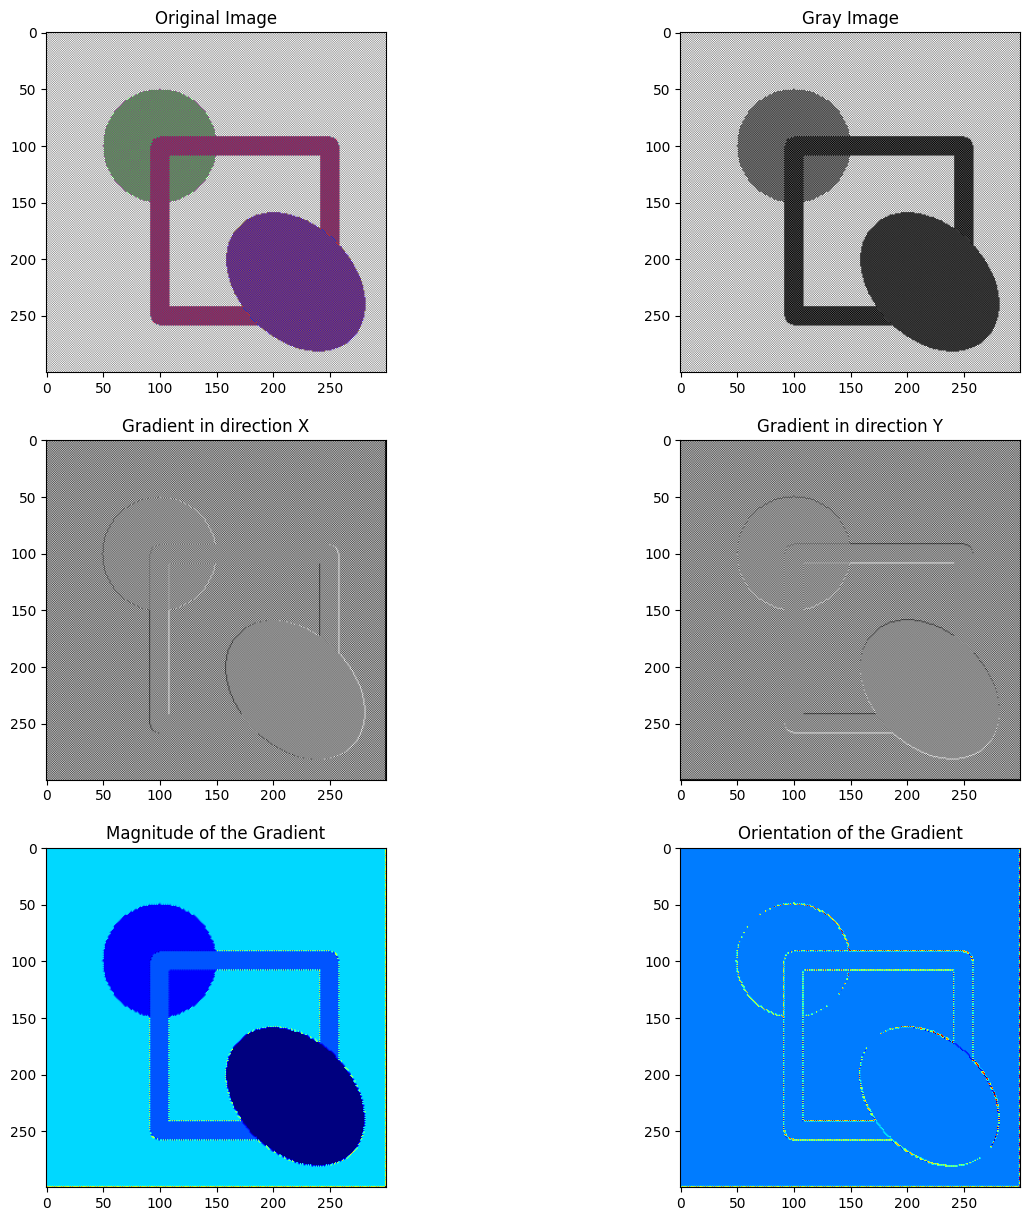

In [5]:
noise = np.zeros(img_rect.shape).astype(np.int8)
for i in range(img_rect.shape[0]):
    for j in range(img_rect.shape[1]):
        if (i%2) ^ (j%2):
            noise[i, j, :] = -1
        else:
            noise[i, j, :] = 1

img_gray, grad_x, grad_y, grad, grad_orient = gradient_simple((img_rect + 50*noise).astype(np.uint8))
show_gradients((img_rect + 50*noise).astype(np.uint8), img_gray, grad_x, grad_y, grad, grad_orient)

## Effects of noise and Sobel filter

The previous approach is simple, elegant and works great on the synthetic examples, but it fails with the very simple noise. Therefore, we need to fix it. To do it we use the ```Sobel``` filter which can be described as follows. The filter to compute the gradient in the x direction is combined from the 2 parts: *smoothing* and *centralized derivative*:

![gradient_x](./img/sobel_x.png)

The Gradient in the y direction looks very similar:

![gradient_y](./img/sobel_y.png)

Let's write the new Sobel-filter edge detection and check it on the previous example:


In [6]:
def gradient_sobel(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    grad_y = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    grad = cv2.magnitude(grad_x, grad_y)
    grad_orient = cv2.phase(np.array(grad_x, np.float32), np.array(grad_y, dtype=np.float32), angleInDegrees=True)
    return img_gray, grad_x, grad_y, grad, grad_orient


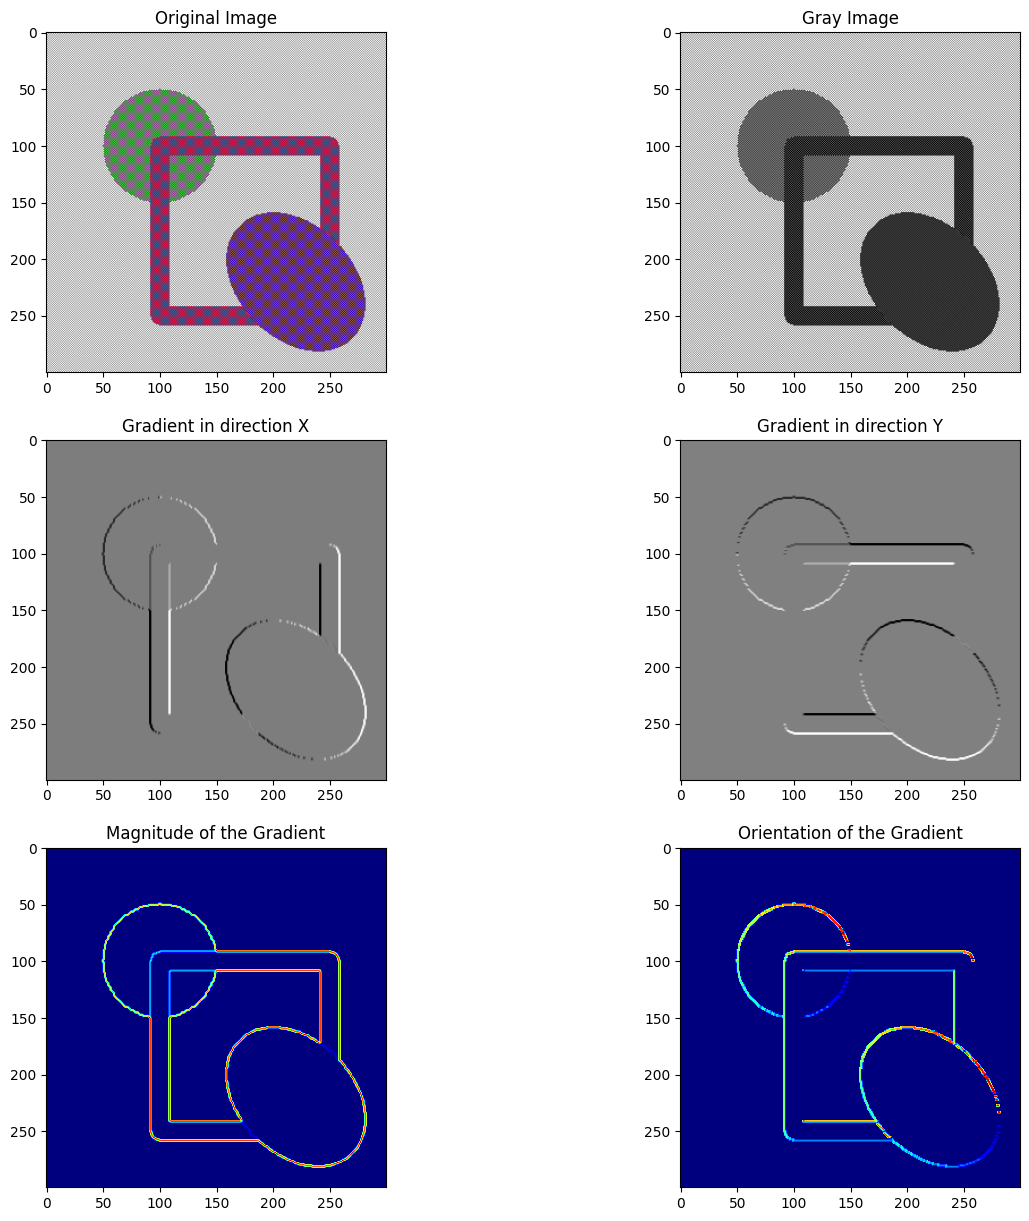

In [7]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_sobel((img_rect + 50*noise).astype(np.uint8))
show_gradients((img_rect + 50*noise).astype(np.uint8), img_gray, grad_x, grad_y, grad, grad_orient)


We see that the Sobel filer overcome the noise problem we intorudced in the previous part. Let's see how it works on the real world examples

In [8]:
img_dog = cv2.imread('img/cute_dog_small.jpg', cv2.IMREAD_COLOR)
imhead = img_dog[100:200, 150:300, :].copy()

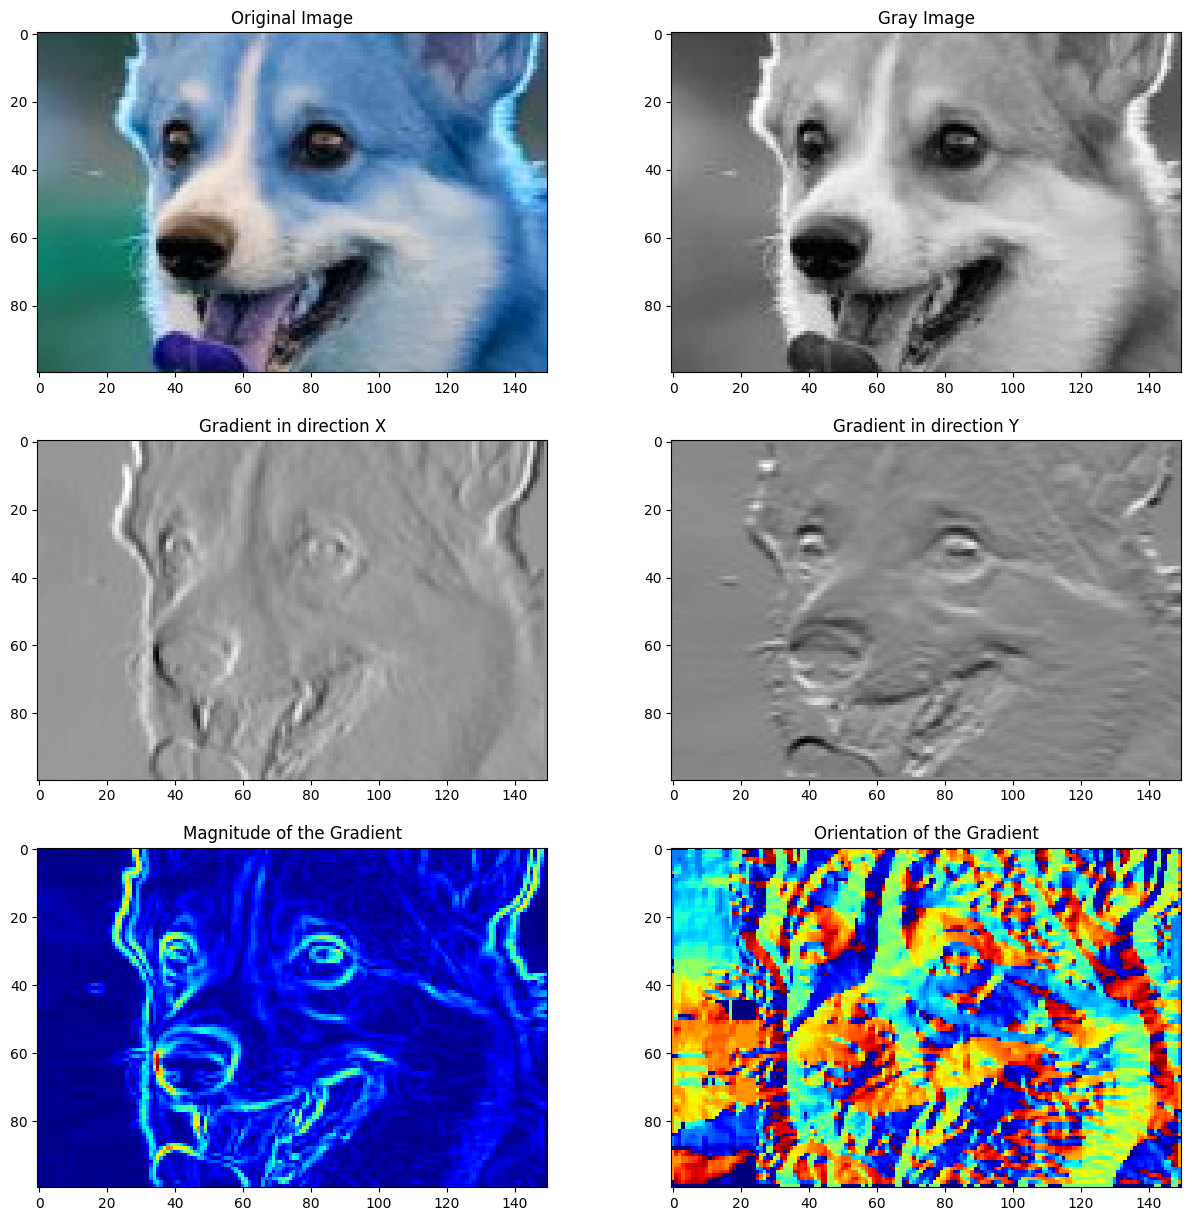

In [9]:
img_gray, grad_x, grad_y, grad, grad_orient = gradient_sobel(imhead)
show_gradients(imhead, img_gray, grad_x, grad_y, grad, grad_orient)


## Canny filter

Still we observe that the filter doesn't work perfect. We still observe weak edges, that we might want to drop. Let's introduce the new filter - ```Canny```. Let’s discuss the actual Canny edge detection algorithm, which is a multi-step process consisting of:

1. Applying Gaussian smoothing to the image to help reduce noise
2. Computing the $G_{x}$ and $G_{y}$ image gradients using the Sobel kernel
3. Applying non-maxima suppression to keep only the local maxima of gradient magnitude pixels that are pointing in the direction of the gradient
4. Defining and applying the $T_\text{upper}$ and $T_\text{lower}$ thresholds for Hysteresis thresholding


In [10]:
def gradient_canny(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(img_gray, 80, 200)
    return img_gray, edge


Text(0.5, 1.0, 'Edges detected by Canny Filter')

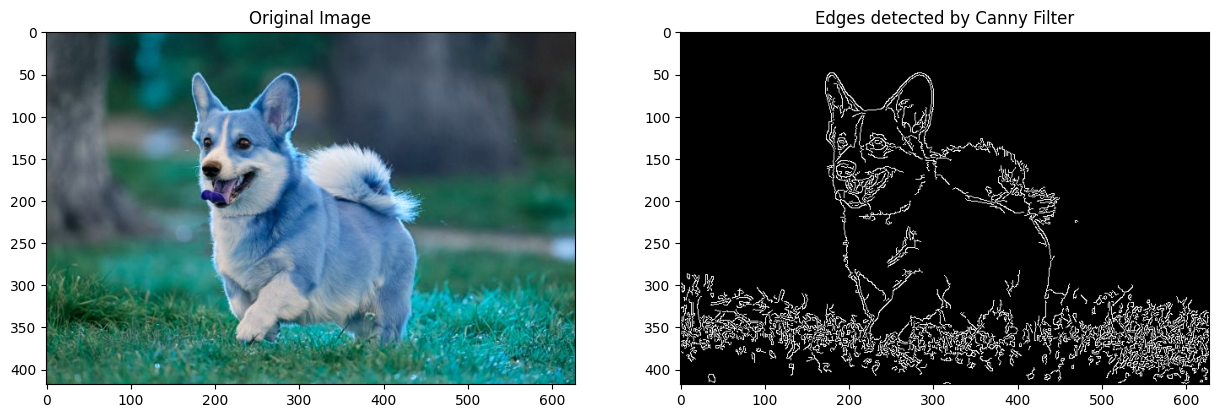

In [11]:
img_gray, edge = gradient_canny(img_dog)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(img_dog)
ax[0].set_title('Original Image')
ax[1].imshow(edge, cmap='gray')
ax[1].set_title('Edges detected by Canny Filter')


## Detecting the lines: Hough transform

Now let's use the Canny edge detection we developed in the previous section to create the Document scanner using the Hough transform.


Text(0.5, 1.0, 'Edges detected by Canny Filter')

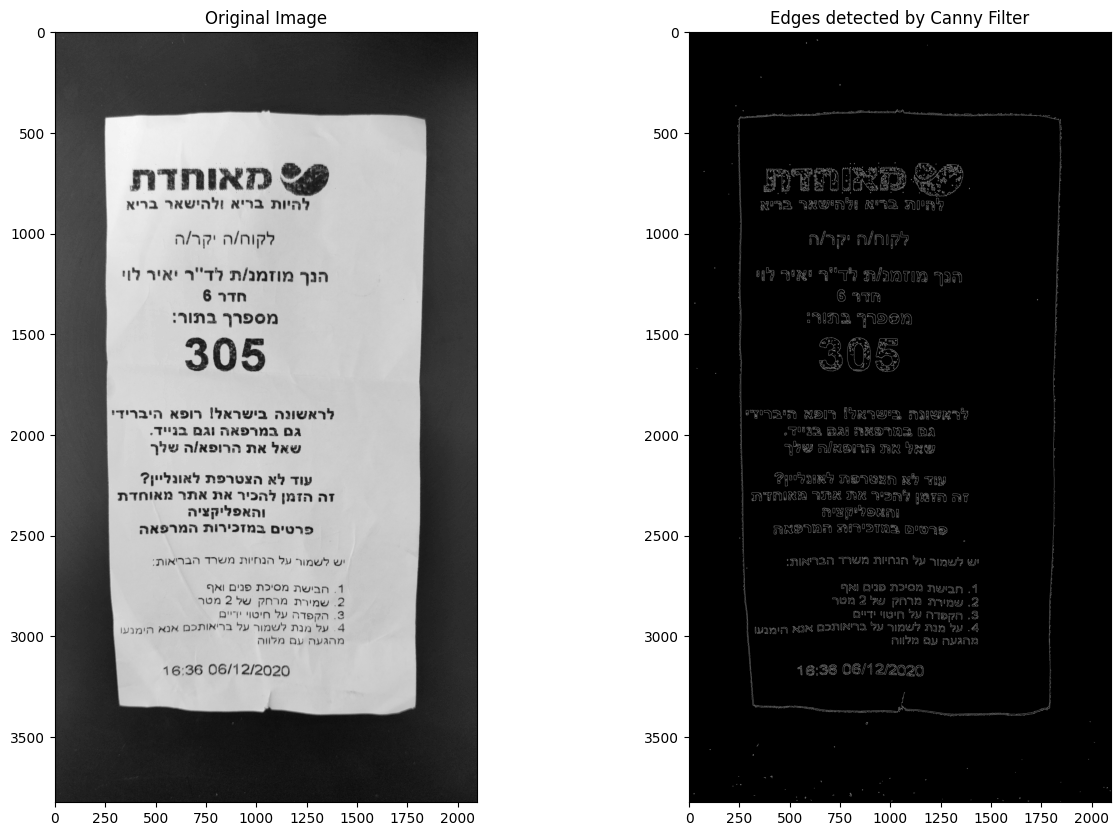

In [12]:
img_ticket = cv2.imread('img/ticket3.jpg', cv2.IMREAD_COLOR)
img_ticket = cv2.cvtColor(img_ticket, cv2.COLOR_BGR2GRAY)
img_ticket_edges = cv2.Canny(img_ticket, 50, 100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].imshow(img_ticket, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_ticket_edges, cmap='gray')
ax[1].set_title('Edges detected by Canny Filter')


For the Hough transform we will use the algorithm implemented in the skimage library:


Text(0, 0.5, 'Distance')

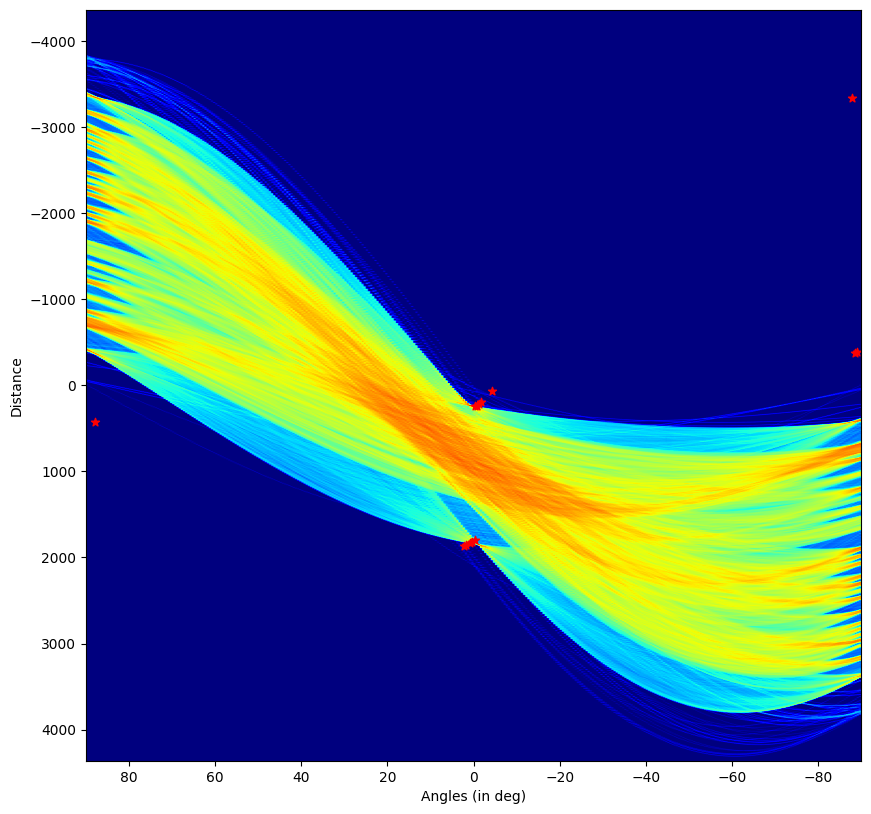

In [21]:
from skimage.transform import hough_line, hough_line_peaks

h, theta, d = hough_line(img_ticket_edges, theta=np.linspace(-np.pi/2, np.pi/2, 360))
v, angle, dist = hough_line_peaks(h, theta, d)

plt.figure(figsize=(10, 10))
plt.imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]], cmap='jet', aspect=1/50)
plt.scatter(np.rad2deg(angle), dist, c='r', marker='*')
plt.xlabel('Angles (in deg)')
plt.ylabel('Distance')


Now let's draw the straight lines we found

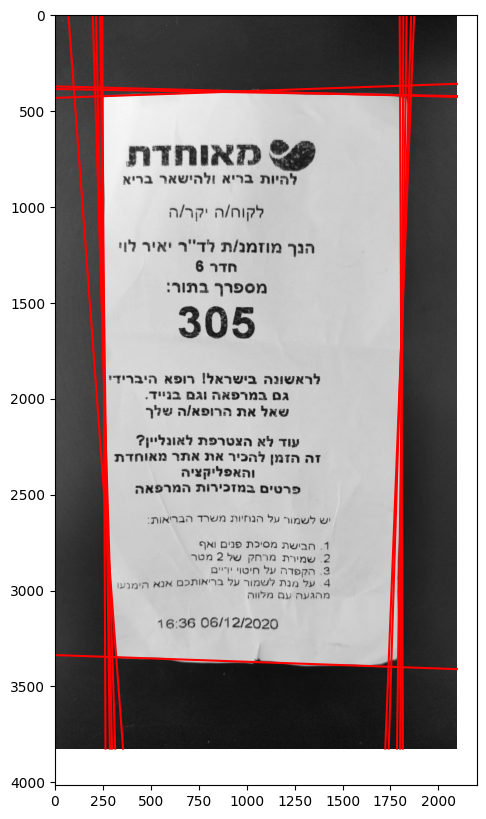

In [14]:
def inside(img, y):
    if y<=0 or y>=img.shape[0]:
        return False
    return True

plt.figure(figsize=(10, 10))
plt.imshow(img_ticket, cmap=cm.gray)
origin = np.array((0, img_ticket.shape[1]))
originy = np.array((0, img_ticket.shape[0]))
for v, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    x0, x1 = (dist - originy * np.sin(angle)) / np.cos(angle)
    #print(f'General angles {(v,np.rad2deg(angle),dist)}')
    if inside(img_ticket,y0) and inside(img_ticket,y1):
        plt.plot(origin, (y0, y1), '-r')
    else:
        plt.plot((x0,x1), originy, '-r')


Please, take a look at the lines we got and try to explain:

1. Why we got multiple lines?
2. How to solve it?
3. How to turn this into the functional Document scanner?
